In [123]:
pip install datatable

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [124]:
pip install memory_profiler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [133]:
import pandas as pd
import numpy as np
import random
import string
from datetime import datetime
import os
from matplotlib import pyplot as plt
import h5py
import warnings
import datatable as dt
import msgpack
import memory_profiler
from sklearn import preprocessing
warnings.simplefilter(action='ignore', category=FutureWarning)

In [126]:
types = ['int', 'float', 'string', 'boolean']

def int_column(length) :

    column = []
    for i in range(length) :
        column.append(random.randint(-2147483648, 2147483647))
    return column

def float_column(length) :
    column = []
    for i in range(length) :
        column.append(random.uniform(-100, 100))
    return column

def boolean_column(length) :
    column = []
    for i in range(length) :
        column.append(bool(random.randint(0,1)))
    return column

def string_column(length) :
    column = []
    letters = string.ascii_lowercase
    for i in range(length) :
        column.append(''.join([random.choice(letters) for j in range(random.randint(0,10))]))
    return column

def column(column_type, length) :
    if types[column_type] == 'int' :
        return int_column(length)
    elif types[column_type] == 'float':
        return float_column(length)
    elif types[column_type] == 'boolean' :
        return boolean_column(length)
    elif types[column_type] == 'string' :
        return string_column(length)

def write_hdf(filename, ds) :
    ds = pd.concat([pd.DataFrame(ds.columns), ds], axis=1)
    new_ds = pd.DataFrame([ds[i].astype('string') for i in ds.columns])
    with h5py.File(filename, 'w') as f:
        f.create_dataset('dataset', data=new_ds.values)

def read_hdf(filename) :
  with h5py.File(filename, "r") as f:
        a_group_key = list(f.keys())[0]
        readed_ds = h5py.Dataset.asstr(f[a_group_key])
        ds = pd.DataFrame(list(readed_ds[1:]))
        ds = ds.T
        ds.columns = list(readed_ds[0])
        return to_correct_types(ds)

def write_jay(filename, ds) :
  ddt = dt.Frame([i.astype(str) for i in ds.values])
  ddt.names = list(ds.columns)
  ddt.to_jay('results/dataset.jay', method='auto')

def read_jay(filename) :
  ddt = dt.fread(filename)
  ds = ddt.to_pandas()
  col = ds.columns
  ind = ds.index
  ds = ds.T
  ds.columns = col
  ds.index = ind
  return to_correct_types(ds)

def write_msgpack(filename, ds) :
  with open(filename, "wb") as outfile:
    packed = msgpack.packb(ds.to_dict())
    outfile.write(packed)

def read_msgpack(filename) :
  with open('results/dataset.msg', "rb") as data_file:
    byte_data = data_file.read()
    data_loaded = msgpack.unpackb(byte_data, strict_map_key=False)
    return pd.DataFrame(data_loaded)

def to_correct_types(ds) :
  for i in range(len(ds.columns)) :
    try :
      ds[ds.columns[i]] = ds[ds.columns[i]].astype('boolean')
    except :
      try :
        ds[ds.columns[i]] = ds[ds.columns[i]].astype('int')
      except :
        try :
          ds[ds.columns[i]] = ds[ds.columns[i]].astype('float64')
        except :
          ds[ds.columns[i]] = ds[ds.columns[i]].astype('string')
  return ds

In [127]:
def saving(ds) :
    before_csv = memory_profiler.memory_usage()[0]
    start_csv = datetime.now()
    ds.to_csv('results/dataset.csv', index=False)

    before_feather = memory_profiler.memory_usage()[0]
    start_feather = datetime.now()
    ds.reset_index(drop=True).to_feather('results/dataset.feather')

    before_hdf = memory_profiler.memory_usage()[0]
    start_hdf = datetime.now()
    write_hdf('results/dataset.hdf5', ds)

    before_msgpack = memory_profiler.memory_usage()[0]
    start_msgpack = datetime.now()
    write_msgpack('results/dataset.msg', ds)

    before_parquet = memory_profiler.memory_usage()[0]
    start_parquet = datetime.now()
    ds.to_parquet('results/dataset.gzip', compression='gzip')

    before_pickle = memory_profiler.memory_usage()[0]
    start_pickle = datetime.now()
    ds.to_pickle('results/dataset.pkl')

    before_jay = memory_profiler.memory_usage()[0]
    start_jay = datetime.now()
    write_jay('results/dataset.jay', ds)

    after = memory_profiler.memory_usage()[0]
    end_time = datetime.now()


    result = pd.DataFrame()
    result['file'] = ['csv', 'feather', 'hdf', 'msgpack', 'parquet', 'pickle', 'jay']
    result['save_time'] = [(start_feather - start_csv).microseconds, (start_hdf - start_feather).microseconds,
                           (start_msgpack - start_hdf).microseconds, (start_parquet - start_msgpack).microseconds,
                           (start_pickle - start_parquet).microseconds, (start_jay - start_pickle).microseconds,
                           (end_time - start_jay).microseconds]
    result['save_memory'] = [abs(before_feather - before_csv), abs(before_hdf - before_feather),
                             abs(before_msgpack - before_hdf), abs(before_parquet - before_msgpack),
                             abs(before_pickle - before_parquet), abs(before_jay - before_pickle),
                             abs(after - before_jay)]
    return result

In [128]:
def loading(ds, result) :
    before_csv = memory_profiler.memory_usage()[0]
    start_csv = datetime.now()
    ds = pd.read_csv('results/dataset.csv')

    before_feather = memory_profiler.memory_usage()[0]
    start_feather = datetime.now()
    ds = pd.read_feather('results/dataset.feather')

    before_hdf = memory_profiler.memory_usage()[0]
    start_hdf = datetime.now()
    ds = read_hdf('results/dataset.hdf5')

    before_msgpack = memory_profiler.memory_usage()[0]
    start_msgpack = datetime.now()
    ds = read_msgpack('results/dataset.msg')

    before_parquet = memory_profiler.memory_usage()[0]
    start_parquet = datetime.now()
    ds = pd.read_parquet('results/dataset.gzip')

    before_pickle = memory_profiler.memory_usage()[0]
    start_pickle = datetime.now()
    ds = pd.read_pickle('results/dataset.pkl')

    before_jay = memory_profiler.memory_usage()[0]
    start_jay = datetime.now()
    ds = read_jay('results/dataset.jay')

    after = memory_profiler.memory_usage()[0]
    end_time = datetime.now()

    result['load_time'] = [(start_feather - start_csv).microseconds, (start_hdf - start_feather).microseconds,
                           (start_msgpack - start_hdf).microseconds, (start_parquet - start_msgpack).microseconds,
                           (start_pickle - start_parquet).microseconds, (start_jay - start_pickle).microseconds,
                           (end_time - start_jay).microseconds]

    result['load_memory'] = [abs(before_feather - before_csv), abs(before_hdf - before_feather),
                             abs(before_msgpack - before_hdf), abs(before_parquet - before_msgpack),
                             abs(before_pickle - before_parquet), abs(before_jay - before_pickle),
                             abs(after - before_jay)]
    return result

In [129]:
def main() :
    #columns_num = random.randint(1, 100)
    #rows_num = random.randint(1, 100)
    #dim = columns_num * rows_num

    ds = pd.DataFrame()
    columns_num = 256
    rows_num = 256

    for i in range(columns_num) :
        type = random.randint(0, 3)
        ds = pd.concat([ds, pd.DataFrame(column(type, rows_num), columns=['col' + str(i) + "_" + types[type]])], axis=1)
        ds.iloc[:, -1] = ds.iloc[:, -1].astype(types[type])

    result = saving(ds)


    result['size'] = [os.stat('results/dataset.csv').st_size, os.stat('results/dataset.feather').st_size,
                      os.stat('results/dataset.hdf5').st_size, os.stat('results/dataset.msg').st_size,
                      os.stat('results/dataset.gzip').st_size, os.stat('results/dataset.pkl').st_size, os.stat('results/dataset.jay').st_size]
    

    result = loading(ds, result)
    
    return result

In [130]:
result = pd.DataFrame(columns=['file', 'save_time', 'save_memory', 'load_time', 'load_memory', 'size'])
for i in range(100) :
        result = pd.concat([result, main()])

res = pd.concat([result[['file', 'save_time', 'load_time', 'size']].groupby('file', as_index=False).mean(), result[['file', 'save_memory', 'load_memory']].groupby('file', as_index=False).mean()], axis=1)
files = res['file']
res = res.drop(res.columns[0], axis=1)

for i in range(len(res.columns)) :
  try:
    res[res.columns[i]] = preprocessing.normalize(res[res.columns[i]].values.reshape(1, -1))[0]
  except :
    's' 

res['sum'] = res['save_time'] + res['load_time'] + res['size'] + res['save_memory'] + res['load_memory']
res['file'] = files.iloc[:,0]
res = res.sort_values(by='sum')
print(res)

   save_time  load_time      size  save_memory  load_memory       sum     file
6   0.243129   0.186365  0.134637     0.361478     0.013196  0.938805   pickle
4   0.366468   0.226662  0.132211     0.185647     0.046046  0.957035  msgpack
0   0.341538   0.215646  0.200847     0.122789     0.112670  0.993490      csv
1   0.304314   0.215854  0.147382     0.232777     0.265962  1.166289  feather
3   0.328591   0.614316  0.264006     0.350514     0.089800  1.647227      jay
5   0.367936   0.241556  0.151831     0.743909     0.919475  2.424707  parquet
2   0.594967   0.620534  0.899767     0.298907     0.246531  2.660706      hdf


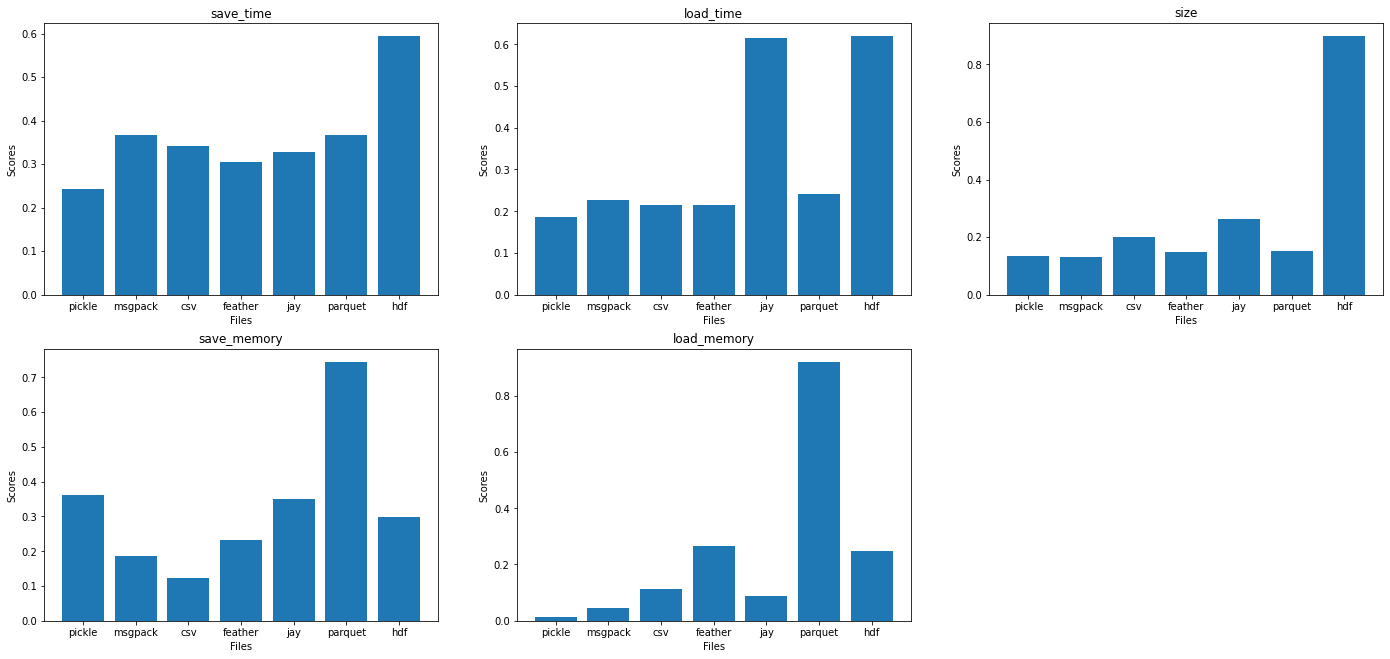

In [150]:
fig = plt.figure(figsize=(24,11))
for i in range(1, 6) :
  plt.subplot(2, 3, i)
  plt.bar(res['file'].values, res[res.columns[i-1]].values)
  plt.title(res.columns[i-1])
  plt.xlabel("Files")
  plt.ylabel("Scores")

plt.savefig('results/features.png')

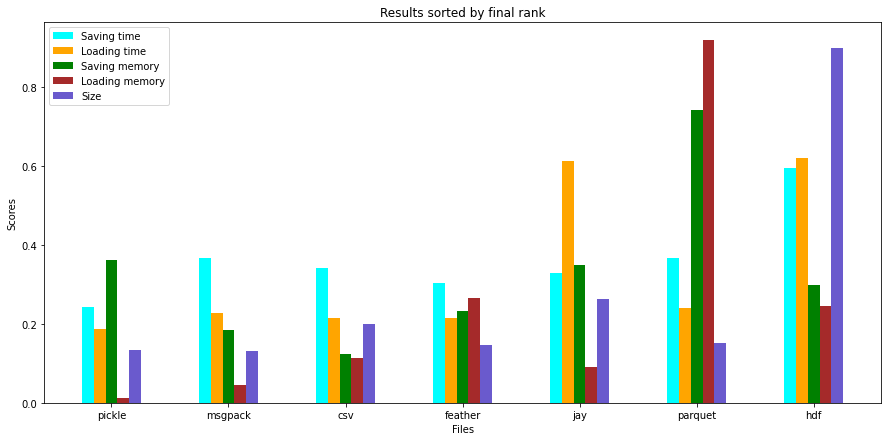

In [151]:
fig = plt.figure(figsize=(15,7))
x = np.arange(7)
width = 0.1
plt.bar(x-0.2, res['save_time'].values, width, color='cyan')
plt.bar(x-0.1, res['load_time'].values, width, color='orange')
plt.bar(x, res['save_memory'].values, width, color='green')
plt.bar(x+0.1, res['load_memory'].values, width, color='brown')
plt.bar(x+0.2, res['size'].values, width, color='slateblue')
plt.xticks(x, res['file'].values)
plt.xlabel("Files")
plt.ylabel("Scores")
plt.title('Results sorted by final rank')
plt.legend(["Saving time", "Loading time", "Saving memory", "Loading memory", "Size"])
plt.savefig('results/all features.png')

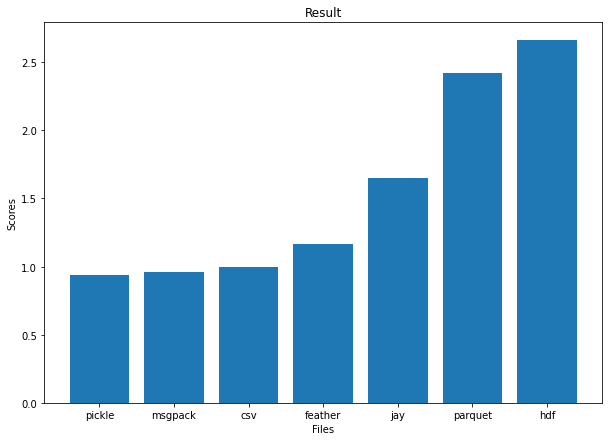

In [152]:
fig = plt.figure(figsize=(10,7))
plt.bar(res['file'].values, res['sum'].values)
plt.title("Result")
plt.xlabel("Files")
plt.ylabel("Scores")

plt.savefig('results/result.png')